In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_curve, auc, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

In [144]:
df = pd.read_csv('car_evaluation.csv', header=None)

In [145]:
df

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [146]:
df.columns =['buying', 'meant', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.head()

,buying,meant,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   meant     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [148]:
df.isnull().sum()

buying      0
meant       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [149]:
df['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

Data splitting

In [150]:
X = df.drop(["class"], axis=1)
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

Data encoding

In [151]:
X_encoder = ce.OrdinalEncoder(cols=['buying', 'meant', 'doors', 'persons', 'lug_boot', 'safety'])

X_train = X_encoder.fit_transform(X_train)
X_test = X_encoder.transform(X_test)


y_encoder = ce.OrdinalEncoder(cols=['class'])

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [152]:
X_train

,buying,meant,doors,persons,lug_boot,safety
107,1,1,1,1,1,1
901,2,1,2,2,2,2
1709,3,2,1,3,1,1
706,4,3,3,3,3,2
678,4,3,2,3,3,3
...,...,...,...,...,...,...
1130,2,3,2,1,3,1
1294,2,2,1,1,1,2
860,4,2,1,1,3,1
1459,3,4,3,3,2,2


In [153]:
y_test

,class
599,1
1201,2
628,1
1498,2
1263,1
...,...
100,1
274,1
1206,1
101,1


In [154]:
y_train['class'] = list(map(lambda x: x - 1, y_train['class']))
y_test['class'] = list(map(lambda x: x - 1 , y_test['class']))
y_train.head()

,class
107,0
901,0
1709,0
706,0
678,0


#### Random Forest

In [155]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')


Accuracy: 0.9653


In [156]:
def get_confusion_matrix(y_test_, y_pred_):
    cm = confusion_matrix(y_test_, y_pred_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

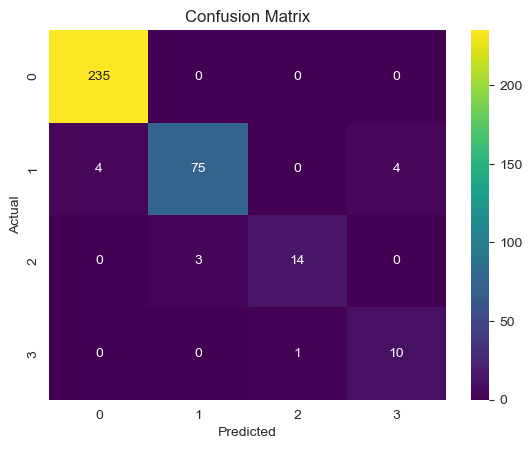

In [157]:
get_confusion_matrix(y_test, y_pred)

In [158]:
def get_roc_curve(y_test, y_pred):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_test))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    overall_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    
    print(f'Overall AUC:{overall_auc:.4f}')
    
    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    
    plt.ylabel('True Positive Rate')
    
    plt.title('Receiver Operating Characteristic')
    
    plt.legend(loc='lower right')
    
    plt.show()

Overall AUC:0.9968


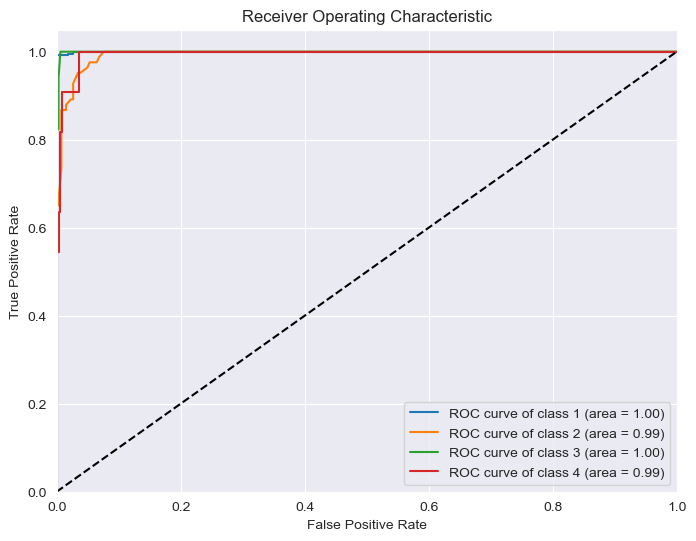

In [159]:
y_score = clf.predict_proba(X_test)
get_roc_curve(y_test, y_score)

In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       235
           1       0.96      0.90      0.93        83
           2       0.93      0.82      0.87        17
           3       0.71      0.91      0.80        11

    accuracy                           0.97       346
   macro avg       0.90      0.91      0.90       346
weighted avg       0.97      0.97      0.97       346


#### Random Forest + Grid Search

In [161]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000, 2000],
    'max_depth': [10, 20, 30],
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

In [162]:
%%time
grid_search.fit(X_train, y_train)
print("The best params:", grid_search.best_params_)
print("The best score:", grid_search.best_score_)

The best params: {'max_depth': 20, 'n_estimators': 500}
The best score: 0.9601946319259141
CPU times: total: 33.3 s
Wall time: 1min 37s


In [163]:
rf_best = grid_search.best_estimator_
y_pred =rf_best.predict(X_test)
y_score = rf_best.predict_proba(X_test)

In [164]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')

Accuracy: 0.9682


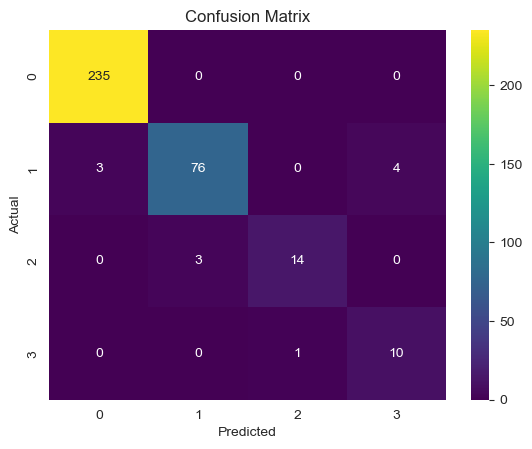

In [165]:
get_confusion_matrix(y_test, y_pred)

Overall AUC:0.9956


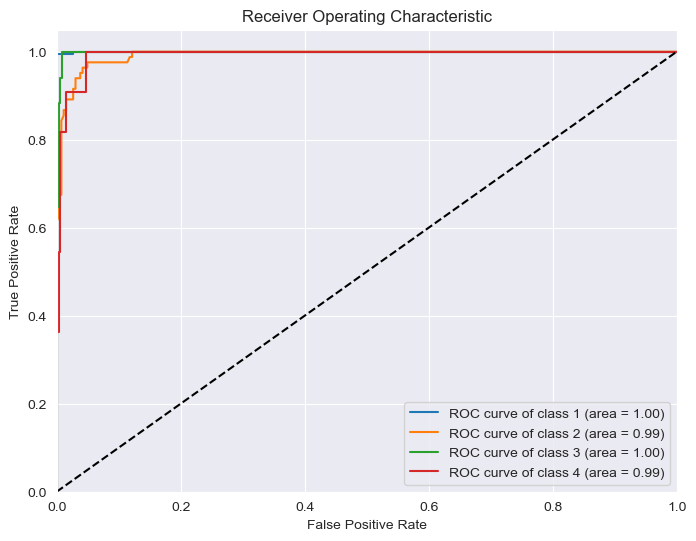

In [166]:
get_roc_curve(y_test, y_score)

In [167]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       235
           1       0.96      0.92      0.94        83
           2       0.93      0.82      0.87        17
           3       0.71      0.91      0.80        11

    accuracy                           0.97       346
   macro avg       0.90      0.91      0.90       346
weighted avg       0.97      0.97      0.97       346


#### XGBoost + Grid Search

In [168]:
xgboost_rf = XGBRFClassifier()
grid_search_xgboost_rf = GridSearchCV(estimator=xgboost_rf, param_grid=param_grid, cv=5, scoring='accuracy')

In [169]:
%%time

grid_search_xgboost_rf.fit(X_train, y_train)
print("Best Parameters:", grid_search_xgboost_rf.best_params_)
print("Best Score:", grid_search_xgboost_rf.best_score_)

Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Best Score: 0.9616412912677236
CPU times: total: 11min 15s
Wall time: 1min 58s


In [170]:
best_xgboost_rf_classifier = grid_search_xgboost_rf.best_estimator_
y_pred_bst = best_xgboost_rf_classifier.predict(X_test)
y_score_bst = best_xgboost_rf_classifier.predict_proba(X_test)

In [171]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_bst):.4f}')

Accuracy: 0.9595


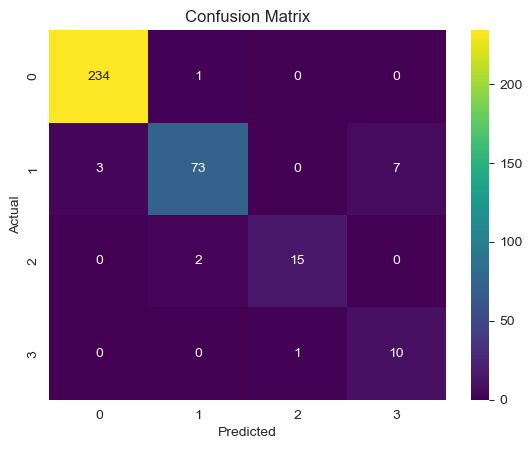

In [172]:
get_confusion_matrix(y_test, y_pred_bst)

Overall AUC:0.9961


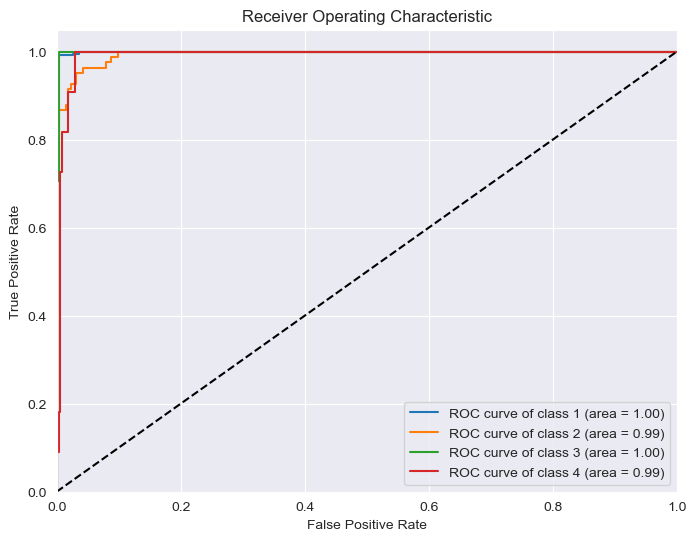

In [173]:
get_roc_curve(y_test, y_score_bst)

In [174]:
print(classification_report(y_test, y_pred_bst))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       235
           1       0.96      0.88      0.92        83
           2       0.94      0.88      0.91        17
           3       0.59      0.91      0.71        11

    accuracy                           0.96       346
   macro avg       0.87      0.92      0.88       346
weighted avg       0.97      0.96      0.96       346


In this lab, I analyzed a car valuation dataset and applied two classification models
Random Forest Classifier and XGBoost. The dataset was examined, pre-processed, and divided into
training and test sets. Both models were trained and optimized using GridSearchCV to find the best hyperparameters.
Random Forest Classifier and XGBoost Random Forest Classifier demonstrated competitiveness as indicated by
in terms of accuracy, confusion matrix, ROC curve, and classification report. These results emphasize
the importance of data preprocessing, model tuning, and thorough evaluation in machine learning applications. Random Forest with the selected hyperparameters using Grid Search performed slightly better than Random Forest with the standard ones. XGBoost is slightly worse than Random Forest.

Translated with DeepL.com (free version)